In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

In [ ]:
import math

In [ ]:
#partition

def Vmax(X):
  X= np.array(X)
  t = np.var(X,axis=0)
  mv = np.argmax(t)
  fp = np.argmax(np.abs(X[:,mv] - np.mean(X,axis=0)[mv]))
  vmax = X[:,mv][fp] - np.mean(X,axis=0)[mv]

  return vmax,mv

def P(X,indces):
  p = X[indces] - np.mean(X[indces],axis=0)
  d={}
  for i in range(len(indces)):d[indces[i]] = p[i]
  return d

def partitionDis2(X,C,tem,length,K_):
  k = len(C)
  if k <= math.ceil(length**(K_)):
    cmax= np.argmax(tem)
    vmax,mv = Vmax(X[C[cmax]])
    p = P(X,C[cmax])
    c1,c2,i1,i2=[],[],[],[]
    for i in C[cmax]:
      if (p[i][mv]*(vmax)) >= 0:c1.append(i)
      else:c2.append(i)
    C.pop(cmax),C.append(c1),C.append(c2)
    tem.pop(cmax),tem.append(sum(np.var(X[c1],axis=0))),tem.append(sum(np.var(X[c2],axis=0)))
    k= len(C)
    partitionDis2(X,C,tem,length,K_)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset_for_me/well_seprated.csv', header=None)
X=np.array(df.iloc[:,:-1])

In [ ]:
gt_lab = np.array(df.iloc[:, -1])

k = len(set(gt_lab))

In [ ]:
C = [np.arange(len(X))]
tem = [sum(np.var(X[i],axis=0)) for i in C]
partitionDis2(X,C,tem,len(X),1/2)

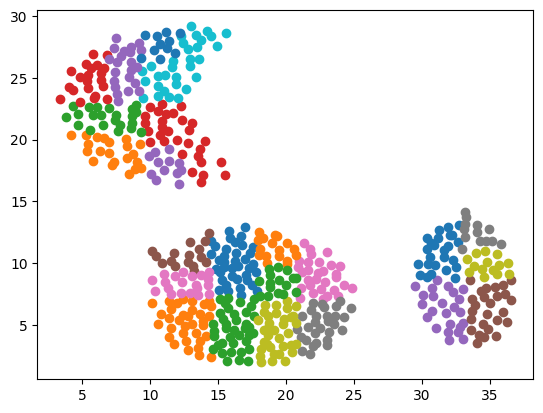

In [ ]:
for i in C:
  plt.scatter(X[i][:,0], X[i][:,1])

In [ ]:
centroids = np.array([X[cluster].mean(axis=0) for cluster in C])

In [ ]:
centroids

array([[16.2       ,  9.95      ],
       [12.73382353,  5.17352941],
       [16.15789474,  4.63947368],
       [11.3047619 , 21.2       ],
       [31.68541667,  6.25833333],
       [34.89038462,  6.26730769],
       [22.45833333,  8.98833333],
       [22.58103448,  4.99137931],
       [19.32      ,  4.42142857],
       [11.415     , 24.9225    ],
       [31.336     , 10.858     ],
       [ 7.23571429, 19.0047619 ],
       [ 6.92727273, 21.77272727],
       [ 5.51904762, 24.83333333],
       [ 8.14318182, 25.84090909],
       [12.58125   , 10.6125    ],
       [12.575     ,  8.33      ],
       [33.98846154, 12.47692308],
       [34.83928571,  9.85      ],
       [13.64545455, 28.19090909],
       [10.82272727, 27.69545455],
       [19.14117647, 11.17352941],
       [19.384375  ,  8.4       ],
       [13.85      , 17.92222222],
       [11.1375    , 17.8375    ]])

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import distance

def k_round_MST_sgmst(X, K, adjMat_precomputed=False, SG=None):
    edges = []

    if not adjMat_precomputed:
        adjMat = np.tril(distance.cdist(X, X, 'euclidean'), -1)
    else:
        adjMat = csr_matrix((len(X), len(X)))
        adjMat[np.array(SG)[:, 0], np.array(SG)[:, 1]] = np.sqrt(np.sum((X[np.array(SG)[:, 0]] - X[np.array(SG)[:, 1]])**2, axis=1))

    for i in range(K):
        Tcsr = minimum_spanning_tree(csr_matrix(adjMat))
        a, b = np.where((Tcsr != 0).toarray())
        edges.append(np.column_stack((a, b)))

        if adjMat_precomputed:
            adjMat -= Tcsr
        else:
            adjMat -= Tcsr.toarray()

    return np.vstack(edges)

In [ ]:
NG = k_round_MST_sgmst(centroids,2)

In [ ]:
import matplotlib.pyplot as plt

def draw_k_round_mst(X, edges, title='K-Round MST'):
    """
    X: data points (n_samples, n_features)
    edges: array of edge pairs (from k_round_MST_sgmst)
    title: plot title
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='red', s=80, zorder=2, label='Points')

    # Draw MST edges
    for i, j in edges:
        x_vals = [X[i][0], X[j][0]]
        y_vals = [X[i][1], X[j][1]]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.6, linewidth=2, zorder=1)

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



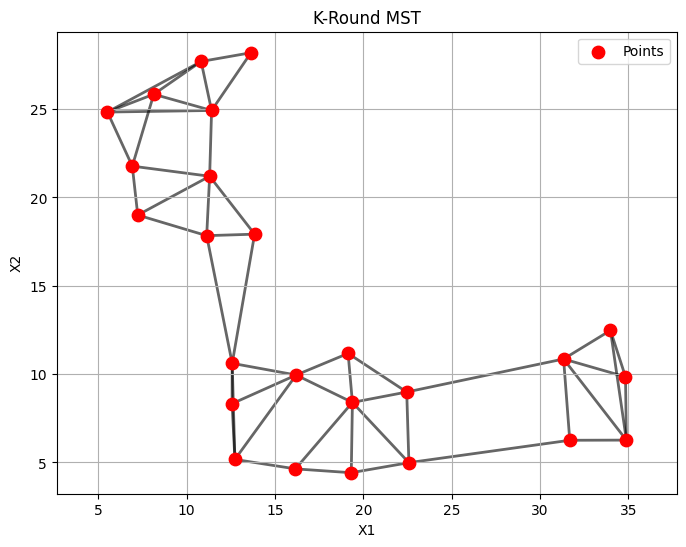

In [ ]:
draw_k_round_mst(centroids,k_round_MST_sgmst(centroids,2))

In [ ]:
def bipartite(p1,p2):
  return [[i,j] for i in p1 for j in p2]

In [ ]:
G = []

for i,j in NG:
  G+= bipartite(C[i],C[j])


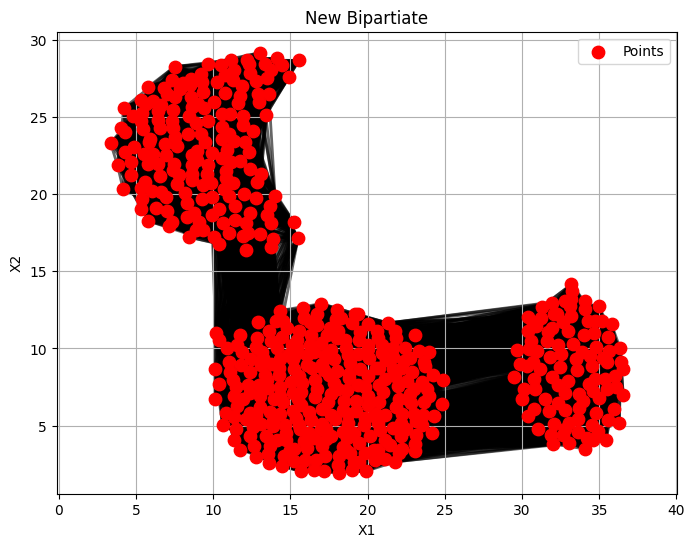

In [ ]:
draw_k_round_mst(X, G, title='New Bipartiate')

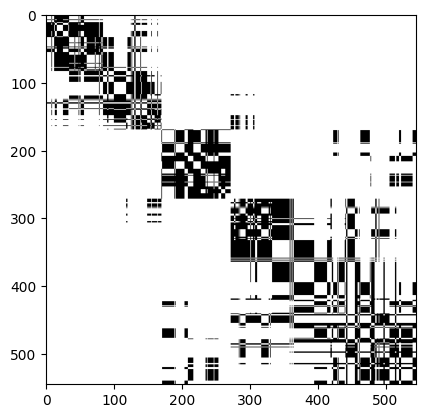

In [ ]:
N, f = X.shape
G = np.array(G)
A = lil_matrix((N, N))
A[G[:, 0], G[:, 1]] = 1
A[G[:, 1], G[:, 0]] = 1
plt.imshow(A.toarray(), cmap='gray_r')

In [ ]:
L, D = laplacian(A, return_diag=True)

In [ ]:
val, vec = eigsh(L, k = k)

In [ ]:
vec

array([[ 2.83379161e-17,  4.56989976e-18,  2.40223483e-06],
       [-5.52482231e-18, -7.48140743e-18,  2.40223483e-06],
       [-7.86991307e-17, -2.90956546e-17,  2.40223483e-06],
       ...,
       [-4.34799562e-17,  6.04648984e-17, -2.45910291e-02],
       [-4.69494031e-17,  6.06868222e-17, -2.45910291e-02],
       [-4.69494031e-17,  4.62542249e-17, -2.45910291e-02]])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical

In [ ]:
# Label remapping

label_mapping = {2:0, 3:1, 4:2}
gt_lab_mapped = np.vectorize(label_mapping.get)(gt_lab)


# One-hot encode the labels

gt_lab_encoded = to_categorical(gt_lab_mapped, num_classes=3)

In [ ]:
# Trian test split
X_train, X_test, y_train, y_test= train_test_split(vec, gt_lab_encoded, test_size=0.2, random_state=42)

In [ ]:
# Model Building

model = Sequential()

model.add(Dense(1024, activation= 'relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.4312 - loss: 1.0809 - val_accuracy: 0.5341 - val_loss: 0.9914
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4841 - loss: 1.0304 - val_accuracy: 0.5341 - val_loss: 0.9777
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5340 - loss: 0.9835 - val_accuracy: 0.5341 - val_loss: 0.9627
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5384 - loss: 0.9456 - val_accuracy: 0.5341 - val_loss: 0.9355
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5097 - loss: 0.9510 - val_accuracy: 0.5341 - val_loss: 0.8784
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4624 - loss: 0.9121 - val_accuracy: 0.5341 - val_loss: 0.7888
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4840 - loss: 0.8020 - val_accuracy: 0.5341 - val_loss: 0.6834
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6183 - loss: 0.7205 - val_accuracy: 0.7386 - val_l

In [ ]:
# Convert one-hot test labels back to integers

y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


In [ ]:
# Remap predictions and test labels back to original (2,3,4)

reverse_mapping = {0:2, 1:3, 2:4}
y_test_original = np.vectorize(reverse_mapping.get)(y_test_labels)
y_pred_original = np.vectorize(reverse_mapping.get)(y_pred_labels)

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test_original, y_pred_original))

Classification Report:

              precision    recall  f1-score   support

           2       0.86      1.00      0.92        42
           3       0.62      0.59      0.61        17
           4       1.00      0.88      0.94        50

    accuracy                           0.88       109
   macro avg       0.83      0.82      0.82       109
weighted avg       0.89      0.88      0.88       109



In [ ]:
acc = accuracy_score(y_test_original, y_pred_original)
prec = precision_score(y_test_original, y_pred_original, average= 'weighted')
rec = recall_score(y_test_original, y_pred_original, average='weighted')



In [ ]:
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')

Accuracy: 0.8807
Precision: 0.8865
Recall: 0.8807
